รายงานแสดงผลการทำนายโรคซึมเศร้า(Psycology) ด้วยวิธี Support Vector Machines (SVM)

นำเข้า library ที่จำเป็นและนำเข้าข้อมูลที่ใช้ในการทำนายผล

In [322]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc


In [323]:
patient = pd.read_excel('Psycology.xls')
patient.head()

,เพศ,อายุ,เคยมีแฟนมาแล้ว (คน),จำนวนครั้งที่ไปออกกำลังกายต่อสัปดาห์,ระยะเวลาการนอน,นิสิยการกินอาหาร,เคยคิดฆ่าตัวตาย,จำนวนชั่วโมงที่เข้าห้องสมุดในหนึ่งสัปดาห์,ระดับความเครียดด้านการเงิน,เคยกินยานอนหลับ,ภาวะซึมเศร้า
0,Male,28,5,3,5-6 ชั่วโมง,อาหารสุขภาพ,Yes,8,3,Yes,Yes
1,Male,23,5,2,มากกว่า 8 ชั่วโมง,อาหารทั่วไป,No,10,4,No,Yes
2,Female,23,1,3,น้อยกว่า 5 ชั่วโมง,อาหารสุขภาพ,Yes,0,3,No,No
3,Female,20,5,5,มากกว่า 8 ชั่วโมง,Junkfood,Yes,2,5,No,Yes
4,Male,29,4,3,มากกว่า 8 ชั่วโมง,Junkfood,Yes,1,3,No,Yes


แสดงข้อมูลของชุดข้อมูล

In [324]:
patient.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502 entries, 0 to 501
Data columns (total 11 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   เพศ                                        502 non-null    object
 1   อายุ                                       502 non-null    int64 
 2   เคยมีแฟนมาแล้ว  (คน)                       502 non-null    object
 3   จำนวนครั้งที่ไปออกกำลังกายต่อสัปดาห์       502 non-null    object
 4   ระยะเวลาการนอน                             502 non-null    object
 5   นิสิยการกินอาหาร                           502 non-null    object
 6   เคยคิดฆ่าตัวตาย                            502 non-null    object
 7   จำนวนชั่วโมงที่เข้าห้องสมุดในหนึ่งสัปดาห์  502 non-null    object
 8   ระดับความเครียดด้านการเงิน                 502 non-null    object
 9   เคยกินยานอนหลับ                            502 non-null    object
 10  ภาวะซึมเศร้า                          

In [325]:
patient['ภาวะซึมเศร้า'].value_counts()

ภาวะซึมเศร้า
Yes    252
No     250
Name: count, dtype: int64

จัดการข้อมูลโดยทำการแปลงข้อมูลที่แปลงข้อมูลประเภทข้อความเป็นตัวเลขโดยใช้ LabelEncoder, แทนค่าข้อมูลที่เป็น '?' ด้วย np.nan และลบค่าที่เป็น Nan ออก

In [326]:
# แปลงค่าที่เป็น '?' เป็น NaN
patient.replace('?', np.nan, inplace=True)

# ลบแถวที่มีค่า NaN
patient.dropna(inplace=True)

# สร้าง LabelEncoder
encoder = LabelEncoder()

# แปลงทุกคอลัมน์ที่เป็น object
for col in patient.columns:
    if patient[col].dtype == 'object':
        patient[col] = encoder.fit_transform(patient[col])

patient.head()


C:\Users\ASUS\AppData\Local\Temp\ipykernel_20632\2315399768.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  patient.replace('?', np.nan, inplace=True)


,เพศ,อายุ,เคยมีแฟนมาแล้ว (คน),จำนวนครั้งที่ไปออกกำลังกายต่อสัปดาห์,ระยะเวลาการนอน,นิสิยการกินอาหาร,เคยคิดฆ่าตัวตาย,จำนวนชั่วโมงที่เข้าห้องสมุดในหนึ่งสัปดาห์,ระดับความเครียดด้านการเงิน,เคยกินยานอนหลับ,ภาวะซึมเศร้า
0,1,28,5.0,3.0,0,2,1,8.0,3.0,1,1
1,1,23,5.0,2.0,3,1,0,10.0,4.0,0,1
2,0,23,1.0,3.0,2,2,1,0.0,3.0,0,0
3,0,20,5.0,5.0,3,0,1,2.0,5.0,0,1
4,1,29,4.0,3.0,3,0,1,1.0,3.0,0,1


In [327]:
#แยก features และ target
col_names = patient.columns.tolist() 
feature_cols = col_names[:-1] 
X = patient[feature_cols]  
y = patient['ภาวะซึมเศร้า']  

# แบ่งข้อมูลออกเป็นชุดฝึก (train) และชุดทดสอบ (test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# ปรับมาตรฐาน
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# สร้างและฝึกโมเดล SVM
clf = svm.SVC(gamma='scale', kernel='rbf', C=1.0, random_state=42)
clf.fit(X_train, y_train)

# ทำนายผลและประเมินโมเดล
y_pred = clf.predict(X_test)

# แสดงผลการวิเคราะห์
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9290780141843972
              precision    recall  f1-score   support

           0       0.92      0.94      0.93        70
           1       0.94      0.92      0.93        71

    accuracy                           0.93       141
   macro avg       0.93      0.93      0.93       141
weighted avg       0.93      0.93      0.93       141



ลองใช้ GridSearchCV โดยจะค้นหาค่าที่ดีที่สุดสำหรับพารามิเตอร์โดยการลองค่าที่กำหนดในแต่ละตัวเลือก

In [328]:
# กำหนดค่าพารามิเตอร์สำหรับ Grid Search
param_grid = {
    'C': [0.1, 1, 10, 100],          # ค่าพารามิเตอร์ C
    'gamma': [1, 0.1, 0.01, 0.001], # ค่าพารามิเตอร์ gamma
    'kernel': ['rbf', 'linear']      # ประเภท kernel
}

# สร้าง GridSearchCV โดยกำหนดจำนวน cross-validation folds
grid = GridSearchCV(
    estimator=SVC(),          # โมเดล SVM
    param_grid=param_grid,    # ค่าพารามิเตอร์ที่ต้องการค้นหา
    refit=True,               # เลือกโมเดลที่ดีที่สุด
    verbose=0,                # แสดง log ระหว่างการรัน
    cv=5                      # ใช้ 5-fold cross-validation
)

# ฝึกโมเดลโดยใช้ GridSearchCV
grid.fit(X_train, y_train)

# แสดงพารามิเตอร์ที่ดีที่สุด
print("Best Parameters:", grid.best_params_)

# ใช้โมเดลที่ดีที่สุดเพื่อทำนาย
y_pred = grid.best_estimator_.predict(X_test)

# แสดงผลการวิเคราะห์
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Best Parameters: {'C': 1, 'gamma': 1, 'kernel': 'linear'}
Accuracy: 0.9574468085106383
              precision    recall  f1-score   support

           0       0.94      0.97      0.96        70
           1       0.97      0.94      0.96        71

    accuracy                           0.96       141
   macro avg       0.96      0.96      0.96       141
weighted avg       0.96      0.96      0.96       141



In [329]:
# แสดงผลลัพธ์ทั้งหมดของการค้นหา
results = pd.DataFrame(grid.cv_results_)
print(results[['param_C', 'param_gamma', 'param_kernel', 'mean_test_score', 'rank_test_score']])


    param_C  param_gamma param_kernel  mean_test_score  rank_test_score
0       0.1        1.000          rbf         0.512261               31
1       0.1        1.000       linear         0.960093                7
2       0.1        0.100          rbf         0.923310               25
3       0.1        0.100       linear         0.960093                7
4       0.1        0.010          rbf         0.717995               29
5       0.1        0.010       linear         0.960093                7
6       0.1        0.001          rbf         0.512261               31
7       0.1        0.001       linear         0.960093                7
8       1.0        1.000          rbf         0.693380               30
9       1.0        1.000       linear         0.969324                1
10      1.0        0.100          rbf         0.938695               20
11      1.0        0.100       linear         0.969324                1
12      1.0        0.010          rbf         0.935618          

แสดง Learning Curve

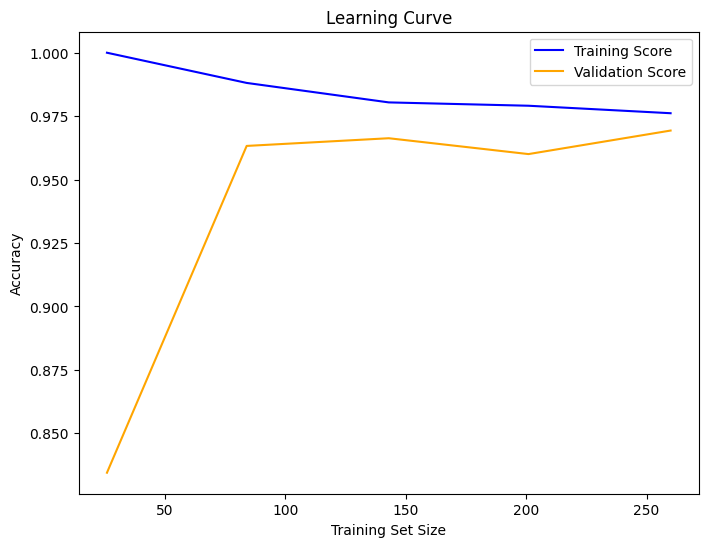

In [330]:
# คำนวณ Learning Curve
train_sizes, train_scores, test_scores = learning_curve(grid.best_estimator_, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)

# คำนวณค่าเฉลี่ยและส่วนเบี่ยงเบน
train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

# วาดกราฟ Learning Curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label="Training Score", color="blue")
plt.plot(train_sizes, test_mean, label="Validation Score", color="orange")
plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


แสดง ROC Curve และ AUC

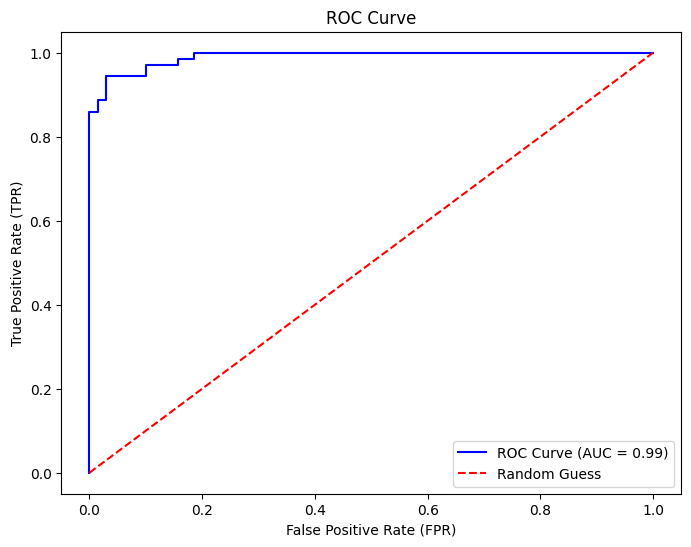

In [331]:
# ทำนายความน่าจะเป็น
y_prob = grid.best_estimator_.decision_function(X_test)

# คำนวณ ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)

# คำนวณ AUC
roc_auc = auc(fpr, tpr)

# วาดกราฟ ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label="Random Guess")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.show()


แสดง Confusion Matrix โดยจะแสดงจำนวนของตัวอย่างที่โมเดลทำนายถูกและผิดในแต่ละคลาส

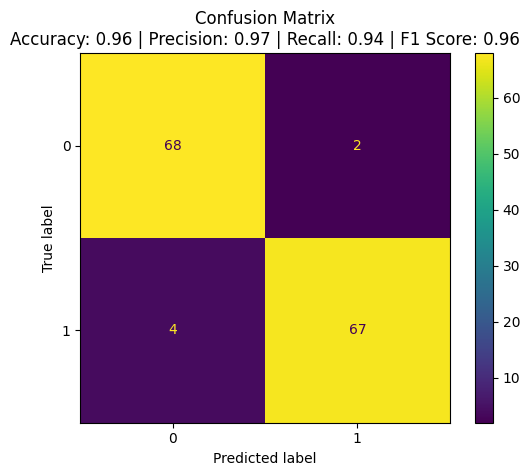

Accuracy: 0.96
Precision: 0.97
Recall: 0.94
F1 Score: 0.96


In [332]:
# ทำนายผลลัพธ์ของชุดข้อมูลทดสอบ
y_pred = grid.best_estimator_.predict(X_test)

# สร้าง Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# คำนวณตัวชี้วัด
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# แสดงผล Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid.best_estimator_.classes_)
disp.plot() 

# เพิ่มข้อมูลตัวชี้วัดในชื่อกราฟ
plt.title(f'Confusion Matrix\nAccuracy: {accuracy:.2f} | Precision: {precision:.2f} | Recall: {recall:.2f} | F1 Score: {f1:.2f}', size=12)
plt.show()

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
